In [2]:
import os, sys, csv, json, re
import numpy as np
import pandas as pd
# import shapefile
from json import dumps
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

def show_process_progress(count, found_count, total_size, pid_name=''):
    percent = count * 100 // total_size
    sys.stdout.write("\rTotal processed: %d; Total found: %d"%(count, found_count) 
                     + "; Progress: {}%".format(percent) + ' ; PID: ' + pid_name)
    sys.stdout.flush()

def list_geojson_properties(geojson):
    print('GeoJson properties:\n' + "; ".join(geojson['properties']))
    print('GeoJson geometry coordinates: ' + str(geojson['geometry']['coordinates'][0][0]))

def dump_json_from_list(out_file_name, json_list):
    with open(out_file_name, 'w') as out:
        out.write(json.dumps({"type": "FeatureCollection", 
                              "crs": { "type": "name", "properties": { "name": "urn:ogc:def:crs:EPSG::2229" }}, 
                              "features": json_list}, indent=2))

def get_polygon_from_geojson_geometry(geometry):
    polygon_list = list()
    if geometry['type'] == 'MultiPolygon':
        for polygon in geometry['coordinates']:
            polygon_list.append(Polygon(polygon[0]))
    elif geometry['type'] == 'Polygon':
        polygon_list.append(Polygon(geometry['coordinates'][0]))
    return polygon_list

## Read City GeoJSON file and clean up dataset

In [5]:
INPUT_FOLDER = 'building-data/la-all-bldgs-json'
DISTRICT_LIST = os.listdir(INPUT_FOLDER)

OUTPUT_FILE_NAME = 'building-data/la-all-bldgs-2229-area-filtered.geojson'
len(DISTRICT_LIST)

38

In [6]:
import csv
use_code_map = dict()
with open('building-data/use-code-map-simple-1.csv', newline='', encoding='utf-8') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
    for row in spamreader:
        use_code_map[str(row[0])] = str(row[1])

In [12]:
original_ct, filtered_ct = 0, 0
area_list = list()
filtered_list = list()
use_type_set = set()
no_use_type = 0
bldg_to_centroid_list = list()
for footprint_file_name in DISTRICT_LIST:
    if footprint_file_name.endswith('geojson'):
        with open(os.path.join(INPUT_FOLDER, footprint_file_name), 'r') as f:
            data = json.load(f)
            for bldg in data['features']:
                original_ct += 1
                geometry = bldg['geometry']
                polygon = get_polygon_from_geojson_geometry(geometry)[0]
                bldg_area = polygon.area

                bldg_id = bldg['properties']['BLD_ID']
                bldg['properties']['area_sqft'] = bldg_area
                
                # Parsing building use code
                use_code = str(bldg['properties']['UseCode14'])

                if use_code != None and use_code in use_code_map:
                    bldg['properties']['use_type'] = use_code_map[use_code]
                else:
                    no_use_type += 1
                    bldg['properties']['use_type'] = None
                use_type_set.add(bldg['properties']['use_type'])
                
                
                # Calculate total_sqft by # stories
                if 'NoStorey' in bldg['properties'] and bldg['properties']['NoStorey'] != None and int(bldg['properties']['NoStorey']) < 100:
                    no_floors = int(bldg['properties']['NoStorey'])
                    bldg['properties']['total_area_sqft'] = bldg_area * no_floors
                elif 'NoStories' in bldg['properties'] and bldg['properties']['NoStories'] != None and int(bldg['properties']['NoStories']) < 100:
                    no_floors = int(bldg['properties']['NoStories'])
                    bldg['properties']['total_area_sqft'] = bldg_area * no_floors
                else:
                    if 'Height_m' in bldg['properties'] and bldg['properties']['Height_m'] != None:
                        no_floors = int(bldg['properties']['Height_m'] / 3.0 + 1)
                    else:
                        no_floors = 1
                    bldg['properties']['total_area_sqft'] = bldg_area * no_floors

                bldg['properties']['no_floors'] = int(no_floors)

#                 if bldg_id in bldg_wrf_map:
#                     bldg['properties']['wrf_id'] = bldg_wrf_map[bldg_id]
#                 else:
#                     bldg['properties']['wrf_id'] = None

                if bldg['properties']['area_sqft'] > 323:
                    area_list.append(bldg['properties']['total_area_sqft'])
                    filtered_list.append(bldg)
                    filtered_ct += 1
                    
                    bldg_centroid = polygon.centroid
                    bldg_to_centroid_list.append((bldg_id, bldg_centroid))
                if original_ct % 1000 == 0:
                    sys.stdout.write("\rTotal bldg processed: %d" % original_ct)
                    sys.stdout.flush()

dump_json_from_list(OUTPUT_FILE_NAME, filtered_list)
print('\nOriginal bldg count: ' + str(original_ct))
print('Filtered bldg count: ' + str(filtered_ct))

Total bldg processed: 1110000Original bldg count: 1110674
Filtered bldg count: 951680


In [13]:
use_type_set

{'Hospital',
 'Hotel',
 'MF',
 None,
 'Office',
 'Restaurant',
 'Retail',
 'SF',
 'School',
 'Warehouse'}

## Map Buildings to WRF grids

In [21]:
FORCING_FOLDER = 'M02_EnergyPlus_Forcing_Historical'

### note: Convert 'wrf-grids-origin.geojson' to 'wrf-grids-2229.geojson' with QGIS!!

In [23]:
count = 0
found = 0
bldg_found = set()
with open(os.path.join(FORCING_FOLDER, 'meta','wrf-grids-2229.geojson'), 'r') as f:
    data = json.load(f)
    for wrf_grid in data['features']:
        count += 1
        wrf_grid['properties']['has_bldgs'] = 0
        if wrf_grid['properties']['domain_flag'] == 1:
            geometry = wrf_grid['geometry']
            wrf_grid['properties']['bldg_ids'] = list()
            wrf_poly = get_polygon_from_geojson_geometry(geometry)[0]
            curr_found = False
            for i in range(len(bldg_to_centroid_list)):
                if i not in bldg_found:
                    bldg = bldg_to_centroid_list[i]
                    bldg_id = bldg[0]
                    bldg_centroid = bldg[1]
                    if wrf_poly.contains(bldg_centroid):
                        bldg_found.add(i)
                        wrf_grid['properties']['bldg_ids'].append(bldg_id)
                        found += 1
                        curr_found = True
            if curr_found:
                wrf_grid['properties']['has_bldgs'] = 1
        if count % 10 == 0:
            sys.stdout.write("\rTotal grid processed: %d, bldg found: %d" % (count, found))
            sys.stdout.flush()
    if count % 10 == 0:
        sys.stdout.write("\rTotal grid processed: %d, found: %d" % (count, found))
        sys.stdout.flush()

Total grid processed: 126610, bldg found: 950800

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [24]:
geojson = open(os.path.join('bldg-wrf-mapping', 'wrf-grids-2229-w-bldgs.geojson'), 'w')
geojson.write(dumps(data, indent=2))
geojson.close()

In [25]:
bldg_to_wrf = {}
with open(os.path.join('bldg-wrf-mapping', 'wrf-grids-2229-w-bldgs.geojson'), 'r') as f:
    wrf_data = json.load(f)
    for wrf_grid in wrf_data['features']:
        if wrf_grid['properties']['has_bldgs'] == 1:
            wrf_id = wrf_grid['properties']['id']
            for bldg_id in wrf_grid['properties']['bldg_ids']:
                bldg_to_wrf[bldg_id] = wrf_id
                
len(bldg_to_wrf)

950121

## Aggregate building-wrf mapping information and write to a simple JSON file

In [29]:
bldg_info_map = dict()

area_list = list()
year_built_list = list()
use_type_list = list()
wrf_id_set = set()

has_height = 0
has_valid_height = 0
has_yearbuilt = 0
has_valid_type = 0
has_no_stories = 0
has_valid_all = 0

with open('building-data/la-all-bldgs-2229-area-filtered.geojson', 'r') as f:
    data = json.load(f)
    for bldg in data['features']:
        bldg_id = bldg['properties']['BLD_ID']
        bldg_area = bldg['properties']['total_area_sqft']
        footprint_area = bldg['properties']['area_sqft']

        area_list.append(bldg_area)
        if bldg_id in bldg_to_wrf:
            wrf_id = bldg_to_wrf[bldg_id]
            wrf_id_set.add(wrf_id)
            
        else:
            print('Bldg ' + str(bldg_id) + ' not found in wrf domain.')

        is_valid = True
        use_type = None
        if 'use_type' in bldg['properties'] and bldg['properties']['use_type'] != None:
            use_type = bldg['properties']['use_type']
            use_type_set.add(use_type)
            use_type_list.append(use_type)
            if use_type in ['Hospital', 'Hotel', 'MF',  'Office', 'Restaurant', 'Retail', 'SF', 'School', 'Warehouse']:
                has_valid_type += 1
            else:
                is_valid = False
        no_stories = 0
        if 'no_floors' in bldg['properties'] and bldg['properties']['no_floors'] != None:
            no_stories = bldg['properties']['no_floors']
        if no_stories > 0:
            has_no_stories += 1
        else:
            is_valid = False
            
        if 'YrBlt' in bldg['properties'] and bldg['properties']['YrBlt'] != None:
            year_built = bldg['properties']['YrBlt']
            year_built_list.append(year_built)
            has_yearbuilt += 1
        else:
            is_valid = False
            year_built = -1
            
        if 'Height_m' in bldg['properties']:
            bldg_height = bldg['properties']['Height_m']
            has_height += 1
            if bldg_height != None and no_stories != None and no_stories > 0:
                height_per_floor = bldg_height / no_stories
                if height_per_floor < 6 and height_per_floor > 2.6:
                    has_valid_height += 1
                else:
                    is_valid = False
        if is_valid:
            has_valid_all += 1
        bldg_info_map[bldg_id] = [wrf_id, use_type, bldg_area, year_built, no_stories, footprint_area]

Bldg 485846738378 not found in wrf domain.
Bldg 486416739778 not found in wrf domain.
Bldg 430606794582 not found in wrf domain.
Bldg 430889794305 not found in wrf domain.
Bldg 2014033149120000 not found in wrf domain.
Bldg 425286806821 not found in wrf domain.
Bldg 424645808225 not found in wrf domain.
Bldg 425161807053 not found in wrf domain.
Bldg 424525808223 not found in wrf domain.
Bldg 425123807141 not found in wrf domain.
Bldg 424549808200 not found in wrf domain.
Bldg 425212806923 not found in wrf domain.
Bldg 425275806855 not found in wrf domain.
Bldg 425152807081 not found in wrf domain.
Bldg 424661808116 not found in wrf domain.
Bldg 425265806882 not found in wrf domain.
Bldg 424809806952 not found in wrf domain.
Bldg 428111800782 not found in wrf domain.
Bldg 425240806970 not found in wrf domain.
Bldg 424587808110 not found in wrf domain.
Bldg 424600808082 not found in wrf domain.
Bldg 425206807039 not found in wrf domain.
Bldg 425139807118 not found in wrf domain.
Bldg 42

Bldg 477058726467 not found in wrf domain.
Bldg 479098726717 not found in wrf domain.
Bldg 476848728282 not found in wrf domain.
Bldg 485464732967 not found in wrf domain.
Bldg 478720725862 not found in wrf domain.
Bldg 480207728064 not found in wrf domain.
Bldg 480007727371 not found in wrf domain.
Bldg 482068729282 not found in wrf domain.
Bldg 478673725947 not found in wrf domain.
Bldg 478845725851 not found in wrf domain.
Bldg 480643727538 not found in wrf domain.
Bldg 481418728314 not found in wrf domain.
Bldg 478847726313 not found in wrf domain.
Bldg 481755725988 not found in wrf domain.
Bldg 480957730954 not found in wrf domain.
Bldg 482067729987 not found in wrf domain.
Bldg 482179729778 not found in wrf domain.
Bldg 486241732758 not found in wrf domain.
Bldg 484886720311 not found in wrf domain.
Bldg 481627724933 not found in wrf domain.
Bldg 475859721313 not found in wrf domain.
Bldg 477081728368 not found in wrf domain.
Bldg 481547728966 not found in wrf domain.
Bldg 481866

Bldg 462482720591 not found in wrf domain.
Bldg 462865720474 not found in wrf domain.
Bldg 462804720688 not found in wrf domain.
Bldg 462814720745 not found in wrf domain.
Bldg 462899720697 not found in wrf domain.
Bldg 463077720621 not found in wrf domain.
Bldg 462553720580 not found in wrf domain.
Bldg 476501728242 not found in wrf domain.
Bldg 472341715304 not found in wrf domain.
Bldg 474950721914 not found in wrf domain.
Bldg 475131721023 not found in wrf domain.
Bldg 469502717771 not found in wrf domain.
Bldg 472601715329 not found in wrf domain.
Bldg 473103715545 not found in wrf domain.
Bldg 474548715900 not found in wrf domain.
Bldg 474403715824 not found in wrf domain.
Bldg 474009715793 not found in wrf domain.
Bldg 469661717790 not found in wrf domain.
Bldg 469706717740 not found in wrf domain.
Bldg 473936715814 not found in wrf domain.
Bldg 462707720467 not found in wrf domain.
Bldg 469827717725 not found in wrf domain.
Bldg 462555720759 not found in wrf domain.
Bldg 475054

In [30]:
(has_height, has_valid_height, has_yearbuilt, has_valid_type, has_no_stories, has_valid_all)

(951680, 926592, 951388, 945647, 951680, 926592)

Text(0, 0.5, '# bldgs')

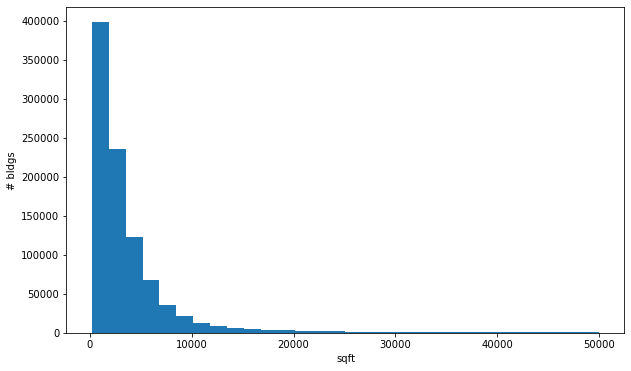

In [31]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist(area_list, 30, range=[200, 50000])
plt.xlabel('sqft')
plt.ylabel('# bldgs')

In [32]:
import pandas as pd
import numpy as np

df_describe = pd.DataFrame()
df_describe['use_type'] = use_type_list
(unique, counts) = np.unique(use_type_list, return_counts=True)
frequencies = np.asarray((unique, counts)).T

print(frequencies)

[['Hospital' '2505']
 ['Hotel' '1264']
 ['MF' '198683']
 ['Office' '19805']
 ['Restaurant' '2147']
 ['Retail' '26950']
 ['SF' '663265']
 ['School' '6675']
 ['Warehouse' '24353']]


In [33]:
len(wrf_id_set)

5806

In [34]:
for bldg_id in bldg_info_map:
    use_code = bldg_info_map[bldg_id][1]
    area = bldg_info_map[bldg_id][2]
    no_floor = bldg_info_map[bldg_id][4]
    if use_code == 'SF':
        if area < 1500:
            bldg_info_map[bldg_id][1] = 'SSF'
        else:
            bldg_info_map[bldg_id][1] = 'LSF'
    elif use_code == 'Hotel':
        if no_floor >= 4 and area > 64583.46:
            bldg_info_map[bldg_id][1] = 'LHotel'
        else:
            bldg_info_map[bldg_id][1] = 'SHotel'
    elif use_code == 'Office':
        if no_floor >= 6 or area > 100000:
            bldg_info_map[bldg_id][1] = 'LOffice'
        elif no_floor <= 3 and area < 2500:
            bldg_info_map[bldg_id][1] = 'SOffice'
        else:
            bldg_info_map[bldg_id][1] = 'MOffice'
    elif use_code == 'Restaurant':
        if no_floor <= 2 or area < 3767.37:
            bldg_info_map[bldg_id][1] = 'SRestaurant'
        else:
            bldg_info_map[bldg_id][1] = 'LRestaurant'
    elif use_code == 'Retail':
        if no_floor <= 2 or area < 13000:
            bldg_info_map[bldg_id][1] = 'SRetail'
        else:
            bldg_info_map[bldg_id][1] = 'LRetail'



In [35]:
len(bldg_info_map)

951001

In [36]:
with open('bldg-wrf-mapping/bldg-info-map.json', 'w') as fp:
    json.dump(bldg_info_map, fp)

In [39]:
with open(os.path.join('bldg-wrf-mapping/bldg-info-map.json'), 'r') as f:
    data = json.load(f)

In [40]:
wrf_to_bldgs = {}
not_found_ct = 0
with open(os.path.join('bldg-wrf-mapping', 'wrf-grids-2229-w-bldgs.geojson'), 'r') as f:
    wrf_data = json.load(f)
    for wrf_grid in wrf_data['features']:
        if wrf_grid['properties']['has_bldgs'] == 1:
            wrf_id = wrf_grid['properties']['id']
            for bldg_id in wrf_grid['properties']['bldg_ids']:
                if bldg_id in data:
                    if data[bldg_id][1] in wrf_to_bldgs:
                        
                        wrf_to_bldgs[data[bldg_id][1]].add(wrf_id)
                    else:
                        wrf_to_bldgs[data[bldg_id][1]] = set([wrf_id])
                else:
                    not_found_ct += 1

In [41]:
not_found_ct

0

In [42]:
for key in wrf_to_bldgs:
    wrf_to_bldgs[key] = list(wrf_to_bldgs[key])

In [43]:
geojson = open(os.path.join('bldg-wrf-mapping','wrf_to_bldgs.json'), 'w')
geojson.write(dumps(wrf_to_bldgs, indent=2))
geojson.close()